# Who is the best Doctor?

### A data-driven analysis of Doctor Who episodes using IMDb ratings

Doctor Who is one of the longest-running sci-fi series in television history, with a rotating cast of lead actors, writers, and directors. In this notebook, we use IMDb ratings to explore the ever important question: *who is the best Doctor?*

We start by collecting and preparing episode-level ratings from IMDb. From there, we explore patterns in episode ratings, look at the performance of each of the different Doctors, and highlight some of the standout writers and directors. Finally, we apply a frequentist linear model to quantify how much of the variation in ratings can be explained by the Doctor - as opposed to the influence of writers and directors. This gives us a deeper understanding of what factors actually drive episode quality.

In [1]:
import sys
import os

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import requests
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

# Add the src directory to sys.path using a relative path
sys.path.append('../utils')
from utils import (
    classic_season_to_doctor_mapping, 
    modern_season_to_doctor_mapping, 
    gatwa_season_to_doctor_mapping,
    doctor_to_actor_mapping,
)

## Downloading IMDb Data

We use IMDb’s official datasets to gather metadata and ratings for Doctor Who episodes. Each dataset is a gzipped .tsv file hosted at [datasets.imdbws.com](https://datasets.imdbws.com), and uses IMDb’s unique identifiers (`tconst` for titles, `nconst` for people).

We'll download the following files:
- `title.basics.tsv.gz` – basic info on all titles
- `title.episode.tsv.gz` – maps episodes to shows
- `title.ratings.tsv.gz` – IMDb ratings
- `title.crew.tsv.gz` – writers and directors
- `name.basics.tsv.gz` – info on people

In [2]:
# Download the data we need for the analysis

imdb_files = {
    "title.basics.tsv.gz": "https://datasets.imdbws.com/title.basics.tsv.gz",
    "title.episode.tsv.gz": "https://datasets.imdbws.com/title.episode.tsv.gz",
    "title.ratings.tsv.gz": "https://datasets.imdbws.com/title.ratings.tsv.gz",
    "title.crew.tsv.gz": "https://datasets.imdbws.com/title.crew.tsv.gz",
    "name.basics.tsv.gz": "https://datasets.imdbws.com/name.basics.tsv.gz"
}

# Download directory
os.makedirs("data/raw", exist_ok=True)

# Download missing files
for filename, url in imdb_files.items():
    path = f"data/raw/{filename}"
    if not os.path.exists(path):
        print(f"Downloading {filename}...")
        r = requests.get(url)
        with open(path, "wb") as f:
            f.write(r.content)
        print("Done")
    else:
        print(f"{filename} already exists.")

title.basics.tsv.gz already exists.
title.episode.tsv.gz already exists.
title.ratings.tsv.gz already exists.
title.crew.tsv.gz already exists.
name.basics.tsv.gz already exists.


## Loading and Filtering Episodes

To focus our analysis, we filter the episode dataset to include only Doctor Who episodes.

There are three relevant IMDb parent IDs:
- `tt0056751` - the classic series (1963 - 1989)
- `tt0436992` - the modern series (2005 - 2022)
- `tt31433814` - the Gatwa era (2023 - present)

We use these to extract episode-level metadata from both eras of the show. 

In [3]:
classic_parentTcode = 'tt0056751'
modern_parentTcode = 'tt0436992'
gatwa_parentTcode = "tt31433814"

In [4]:
# Load the episodes dataset
t_episode = pd.read_csv(
    "data/raw/title.episode.tsv.gz",
    sep="\t",
    dtype=str,
    na_values="\\N",
)

# Get episodes from the classic and modern series
episodes = t_episode[t_episode['parentTconst'].isin([classic_parentTcode, modern_parentTcode, gatwa_parentTcode])]

In [5]:
# For simplicity, we will also drop any episodes which don't have a seasonNumber, or have an episodeNumber which is less than 1. 
# This will get rid of Christmas specials and the like.
episodes = episodes.dropna(subset=["seasonNumber"])

episodes = episodes[
    pd.to_numeric(episodes["episodeNumber"], errors="coerce") >= 1
]

In [6]:
# Since this will be helpful later, let's collect all the tconst codes 
classical_tconst_codes = list(episodes[episodes["parentTconst"]==classic_parentTcode]["tconst"].unique())
modern_tconst_codes = list(episodes[episodes["parentTconst"]==modern_parentTcode]["tconst"].unique())
gatwa_tconst_codes = list(episodes[episodes["parentTconst"]==gatwa_parentTcode]["tconst"].unique())

# It will also be useful to have a list of the doctors in the order in which they appeared
doctor_order = list(doctor_to_actor_mapping.values())

## Enriching with Metadata and Ratings

Next, we pull in a bit more context for each episode by merging:
- The `basics` dataset for title, year, and runtime
- The `ratings` dataset for IMDb user scores

Later, we will also add in the director and writers.


In [7]:
# Load the basics dataset
t_basics = pd.read_csv(
    "data/raw/title.basics.tsv.gz",
    sep="\t",
    dtype=str,
    na_values="\\N",
)

episode_details = episodes.merge(t_basics, on="tconst", how="left")

In [8]:
# Load the ratings dataset
t_ratings = pd.read_csv(
    "data/raw/title.ratings.tsv.gz",
    sep="\t",
    dtype=str,
    na_values="\\N",
)
 
episode_details = episode_details.merge(t_ratings, on="tconst", how="left")

## Adding the Doctor to Each Episode

Each Doctor Who episode features a particular incarnation of the Doctor, portrayed by a different actor. Since IMDb doesn't tell us which Doctor appears in which episode, we assign one based on the era (classical, modern, or gatwa) and Season, using information sourced from the [Wikipedia article](https://en.wikipedia.org/wiki/List_of_Doctor_Who_episodes_%282005%E2%80%93present%29). 


In [9]:
# If the era is classical, use the classical_season_to_doctor mapping dict to find the appropriate doctor from the season number
# Similarly, if the era is modern, use modern. If the era is gatwa, use gatwa.


episode_details["seasonNumber"] = pd.to_numeric(episode_details["seasonNumber"], errors="coerce").astype("Int64")

episode_details["doctor"] = episode_details.apply(
    lambda row: (
        classic_season_to_doctor_mapping.get(row["seasonNumber"])
        if row["parentTconst"] == classic_parentTcode else
        modern_season_to_doctor_mapping.get(row["seasonNumber"])
        if row["parentTconst"] == modern_parentTcode else
        gatwa_season_to_doctor_mapping.get(row["seasonNumber"])
        if row["parentTconst"] == gatwa_parentTcode else
        None
    ),
    axis=1
)

## Merging the Crew

To understand how much influence the behind-the-scenes team has on episode ratings, we add metadata for writers and directors. This information comes from the IMDb `title.crew` and `name.basics` datasets, which we join to match crew members to each episode.


In [10]:
# Load the crew dataset
t_crew = pd.read_csv(
    "data/raw/title.crew.tsv.gz",
    sep="\t",
    dtype=str,
    na_values="\\N"
)

# Load the name crew dataset
n_basics = pd.read_csv(
    "data/raw/name.basics.tsv.gz",
    sep="\t",
    dtype=str,
    na_values="\\N"
)

In [11]:
# Merge the crew information into the episode_details DataFrame
episode_details = episode_details.merge(t_crew, on="tconst", how="left")

In [12]:
# At the moment, the crew are identified by their nconst codes. Let us replace the codes with names from the n_basics DataFrame

# Define a mapping from nconst to name. This is not optimal, but it's too small of a DataFrame to worry about
nconst_to_name = dict(zip(n_basics['nconst'], n_basics['primaryName'])) 

# Define a helper function 
def replace_nconsts_with_names(nconst_str):
    if pd.isna(nconst_str):
        return ''
    return ', '.join(nconst_to_name.get(nconst.strip(), nconst.strip()) for nconst in nconst_str.split(','))

# Apply the helper function to the relevant columns
for col in ['directors', 'writers']:
    if col in episode_details.columns:
        episode_details[col] = episode_details[col].apply(replace_nconsts_with_names)

## Cleaning the data

With everything merged, we can now clean up the dataset: we drop unnecessary columns, set data types, rename inconveniently named columns of the DataFrame, and fix any quirks in the formatting. This makes the data easier to work with and ensures consistency for the analysis to come.

In [13]:
# Drop unnnecessary columns
episode_details = episode_details.drop(["isAdult", "endYear", "originalTitle", "titleType", "genres"], axis=1)

# Change parentTconst to refer to "classical", "modern", or "gatwa"
episode_details["parentTconst"] = episode_details["parentTconst"].replace({"tt0056751": "classical", "tt0436992": "modern", "tt31433814": "gatwa"})


# Rename confusing columns
episode_details = episode_details.rename(columns={
                                            "primaryTitle":"title", 
                                            "startYear":"year", 
                                            "seasonNumber":"season", 
                                            "episodeNumber":"episode",
                                            "averageRating": "rating",
                                            "numVotes": "votes",
                                            "runtimeMinutes": "runtime",
                                            "parentTconst": "era"
                                            })

# Replace number of the Doctor with with the name of the actor
episode_details["doctor"] = episode_details["doctor"].map(doctor_to_actor_mapping)

# Set data types for numeric and categorical columns
int_columns = [
    "season",
    "episode",
    "year",
    "runtime",
    "votes"
]

for col in int_columns:
    if col in episode_details.columns:
        episode_details[col] = pd.to_numeric(episode_details[col], errors="coerce").astype('Int64')

episode_details["rating"] = pd.to_numeric(episode_details["rating"], errors="coerce")

episode_details["doctor"] = pd.Categorical(
    episode_details["doctor"],
    categories=doctor_order,
    ordered=True
)

# Drop any columns with NA ratings (for example, if the episode is listed but there has not yet been released)
episode_details = episode_details.dropna()


# Print the number of episodes
print(f"Total number of episodes in DataFrame: {len(episode_details)}")

Total number of episodes in DataFrame: 863


In [14]:
# Preview of the merged and cleaned DataFrame
episode_details.sample(random_state=7, n=6).style.hide(axis="index").format(precision=1)

tconst,era,season,episode,title,year,runtime,rating,votes,doctor,directors,writers
tt2378951,modern,7,5,The Angels Take Manhattan,2012,44,8.9,9728,Matt Smith,Nick Hurran,"Steven Moffat, Sydney Newman"
tt2222152,modern,7,7,The Bells of Saint John,2013,45,7.8,7078,Matt Smith,Colm McCarthy,"Steven Moffat, Sydney Newman"
tt0811453,classical,6,3,The Dominators: Episode 3,1968,24,6.0,516,Patrick Troughton,Morris Barry,"Mervyn Haisman, Henry Lincoln, Sydney Newman, Donald Wilson"
tt0811846,classical,26,14,Survival: Part Three,1989,25,7.4,595,Sylvester McCoy,Alan Wareing,"Rona Munro, Sydney Newman"
tt0811864,classical,16,24,The Armageddon Factor: Part Four,1979,25,6.9,459,Tom Baker,Michael Hayes,"Bob Baker, Dave Martin, Sydney Newman, Donald Wilson"
tt0811317,classical,6,20,The Krotons: Episode Two,1969,23,6.6,498,Patrick Troughton,David Maloney,"Robert Holmes, Sydney Newman, Donald Wilson"


## Exploring Extremes in Episode Ratings

We start by identifying the highest- and lowest-rated episodes across all of Doctor Who. This helps us see which stories resonate most (or least) with viewers.

We'll look at:
- Top 10 rated episodes
- Bottom 10 rated episodes


In [15]:
# Which are the best-rated episodes?
best_eps = episode_details.sort_values(
    by=["rating", "votes"], 
    ascending=[False, False]
).iloc[0:10]

best_eps.style.hide(axis="index").format(precision=1)

tconst,era,season,episode,title,year,runtime,rating,votes,doctor,directors,writers
tt1000252,modern,3,10,Blink,2007,45,9.8,25531,David Tennant,Hettie Macdonald,"Steven Moffat, Sydney Newman"
tt4701542,modern,9,11,Heaven Sent,2015,55,9.6,13853,Peter Capaldi,Rachel Talalay,"Steven Moffat, Sydney Newman"
tt1205440,modern,4,9,Forest of the Dead,2008,45,9.4,12017,David Tennant,Euros Lyn,"Steven Moffat, Sydney Newman"
tt1591786,modern,5,10,Vincent and the Doctor,2010,47,9.3,13773,Matt Smith,Jonny Campbell,"Richard Curtis, Steven Moffat, Sydney Newman"
tt1208129,modern,4,8,Silence in the Library,2008,43,9.3,11727,David Tennant,Euros Lyn,"Steven Moffat, Sydney Newman"
tt0562998,modern,2,4,The Girl in the Fireplace,2006,45,9.2,13738,David Tennant,Euros Lyn,"Steven Moffat, Sydney Newman"
tt0756450,modern,2,13,Doomsday,2006,45,9.2,11179,David Tennant,Graeme Harper,"Russell T. Davies, Terry Nation, Kit Pedler, Gerry Davis, Sydney Newman"
tt1000256,modern,3,9,The Family of Blood,2007,45,9.2,10824,David Tennant,Charlie Palmer,"Paul Cornell, Sydney Newman"
tt1205438,modern,4,13,Journey's End,2008,63,9.2,10403,David Tennant,Graeme Harper,"Russell T. Davies, Terry Nation, Bob Baker, Dave Martin, Sydney Newman"
tt1208128,modern,4,10,Midnight,2008,45,9.1,11060,David Tennant,Alice Troughton,"Russell T. Davies, Sydney Newman"


In [16]:
# Which are the worst-rated episodes?
worst_eps = episode_details.sort_values(
    by=["rating", "votes"], 
    ascending=[True, False]
).iloc[0:10]

worst_eps.style.hide(axis="index").format(precision=1)

tconst,era,season,episode,title,year,runtime,rating,votes,doctor,directors,writers
tt9354208,modern,12,3,Orphan 55,2020,46,4.2,7205,Jodie Whittaker,Lee Haven Jones,"Ed Hime, Chris Chibnall"
tt0811350,classical,6,34,The Space Pirates: Episode 6,1969,24,4.7,323,Patrick Troughton,Michael Hart,"Robert Holmes, Sydney Newman, Donald Wilson"
tt0811349,classical,6,33,The Space Pirates: Episode 5,1969,25,4.9,319,Patrick Troughton,Michael Hart,"Robert Holmes, Sydney Newman, Donald Wilson"
tt0811347,classical,6,31,The Space Pirates: Episode 3,1969,24,5.0,321,Patrick Troughton,Michael Hart,"Robert Holmes, Sydney Newman, Donald Wilson"
tt0811348,classical,6,32,The Space Pirates: Episode 4,1969,23,5.0,319,Patrick Troughton,Michael Hart,"Robert Holmes, Sydney Newman, Donald Wilson"
tt28289436,gatwa,1,1,Space Babies,2024,46,5.1,9141,Ncuti Gatwa,Julie Anne Robinson,Russell T. Davies
tt7689200,modern,11,4,Arachnids in the UK,2018,49,5.1,8741,Jodie Whittaker,Sallie Aprahamian,Chris Chibnall
tt7693260,modern,11,5,The Tsuranga Conundrum,2018,50,5.1,8162,Jodie Whittaker,Jennifer Perrott,"Chris Chibnall, Tim Price"
tt9361046,modern,12,10,The Timeless Children,2020,66,5.1,6814,Jodie Whittaker,Jamie Magnus Stone,"Chris Chibnall, Kit Pedler, Gerry Davis, Russell T. Davies"
tt0562958,classical,6,29,The Space Pirates: Episode 1,1969,24,5.1,342,Patrick Troughton,Michael Hart,"Robert Holmes, Sydney Newman, Donald Wilson"


In [17]:
# What about the top-rated episode per doctor?
top_rated_per_doctor = episode_details.loc[episode_details.groupby("doctor", observed=True)["rating"].idxmax()]
top_rated_per_doctor[["rating", "doctor", "title"]].style.hide(axis="index").format(precision=1)

rating,doctor,title
8.4,William Hartnell,Destruction of Time
9.1,Patrick Troughton,The War Games: Episode Ten
8.4,Jon Pertwee,Inferno: Episode 3
9.1,Tom Baker,Genesis of the Daleks: Part Six
8.8,Peter Davison,The Caves of Androzani: Part Four
7.6,Colin Baker,Revelation of the Daleks: Part Two
8.5,Sylvester McCoy,Remembrance of the Daleks: Part Four
9.0,Christopher Eccleston,The Doctor Dances
9.8,David Tennant,Blink
9.3,Matt Smith,Vincent and the Doctor


## Number of votes: classical vs. modern
Since the original episodes of Doctor Who came out before the internet had been invented, it seems obvious that the episodes from earlier seasons are likely to have fewer votes per episode than the episode from the modern or gatwa eras. We can see this in the following chart.

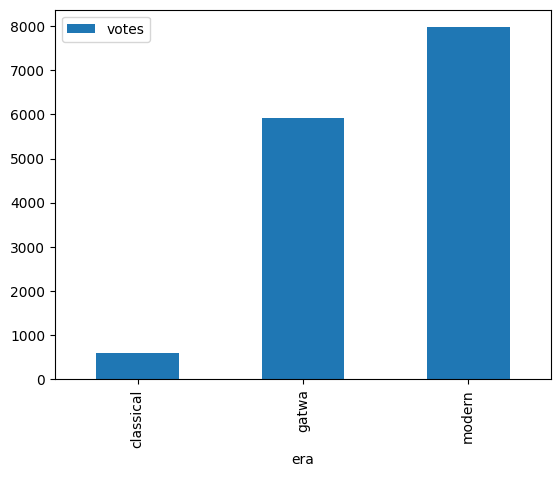

In [18]:
# Plot a bar chart of the average votes per episode for the different eras
votes_by_era = episode_details.groupby("era")[["votes"]].mean()
votes_by_era.plot(kind="bar")
plt.show()

## Visualizing Episode Ratings by Season

Next, we create a heatmap of ratings by season and episode number.  It gives a quick visual summary of consistency, standout episodes, and rough patches across both the classic and modern series. Higher-rated episodes appear in red, while lower-rated ones are shown in blue — making the hits and misses easy to spot at a glance.

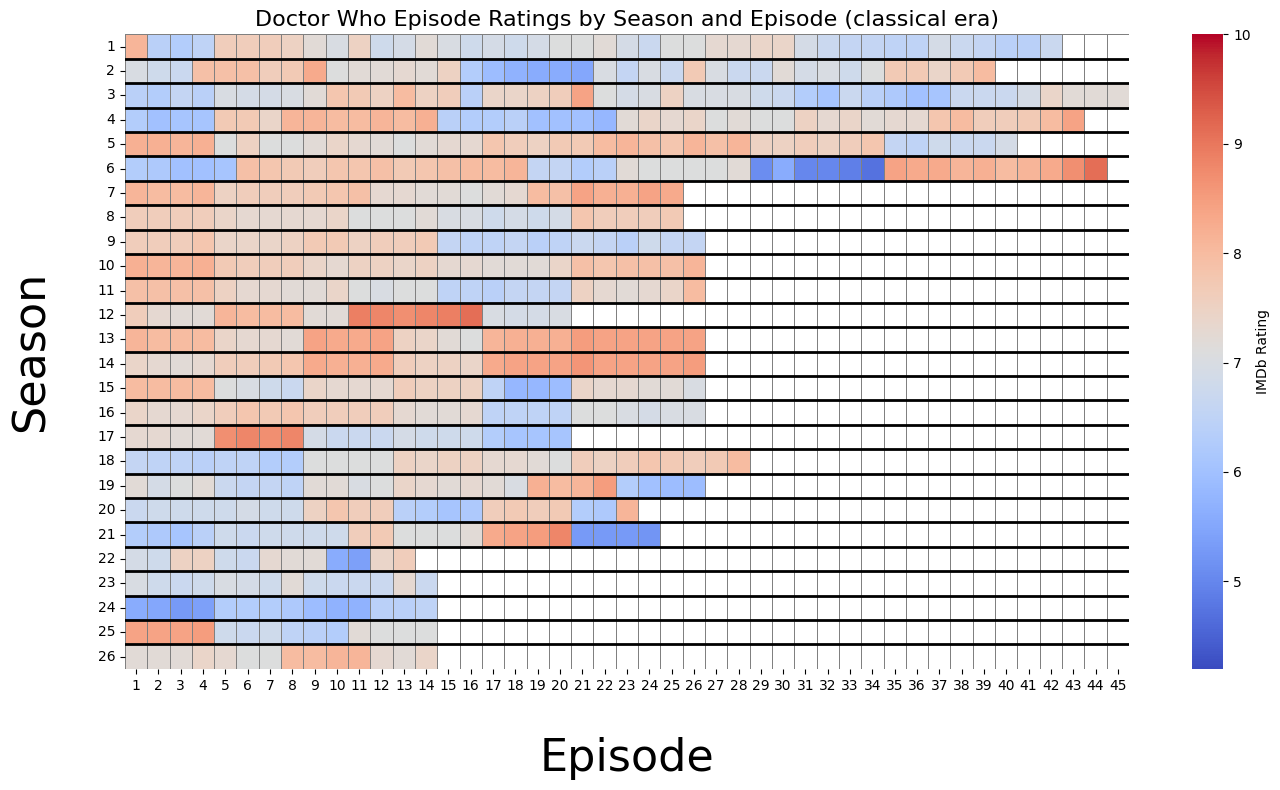

In [19]:
# Pivot the data so each row is a season and each column is an episode number
heatmap_data = episode_details[episode_details["era"] == "classical"].pivot_table(
    index="season",
    columns="episode",
    values="rating"
)

# Get the global min value for scale
heatmap_vmin = episode_details["rating"].min()


# Create the heatmap
plt.figure(figsize=(14, 8))
ax = sns.heatmap(
    heatmap_data,
    annot=False,
    fmt=".1f",
    cmap="coolwarm",
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "IMDb Rating"},
    vmin=heatmap_vmin,
    vmax=10.0,
)

# Add horizontal lines between seasons
for y in range(1, len(heatmap_data.index)):
    ax.axhline(y=y, color='black', linewidth=2)

plt.title("Doctor Who Episode Ratings by Season and Episode (classical era)", fontsize=16)
plt.xlabel("Episode", fontsize=32, labelpad=32)
plt.ylabel("Season", rotation=90, labelpad=32, fontsize=32)

plt.xticks(ticks=np.arange(len(heatmap_data.columns))+0.5, labels=heatmap_data.columns.astype(int), fontsize=10)
plt.yticks(ticks=np.arange(len(heatmap_data.index))+0.5, labels=heatmap_data.index.astype(int), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

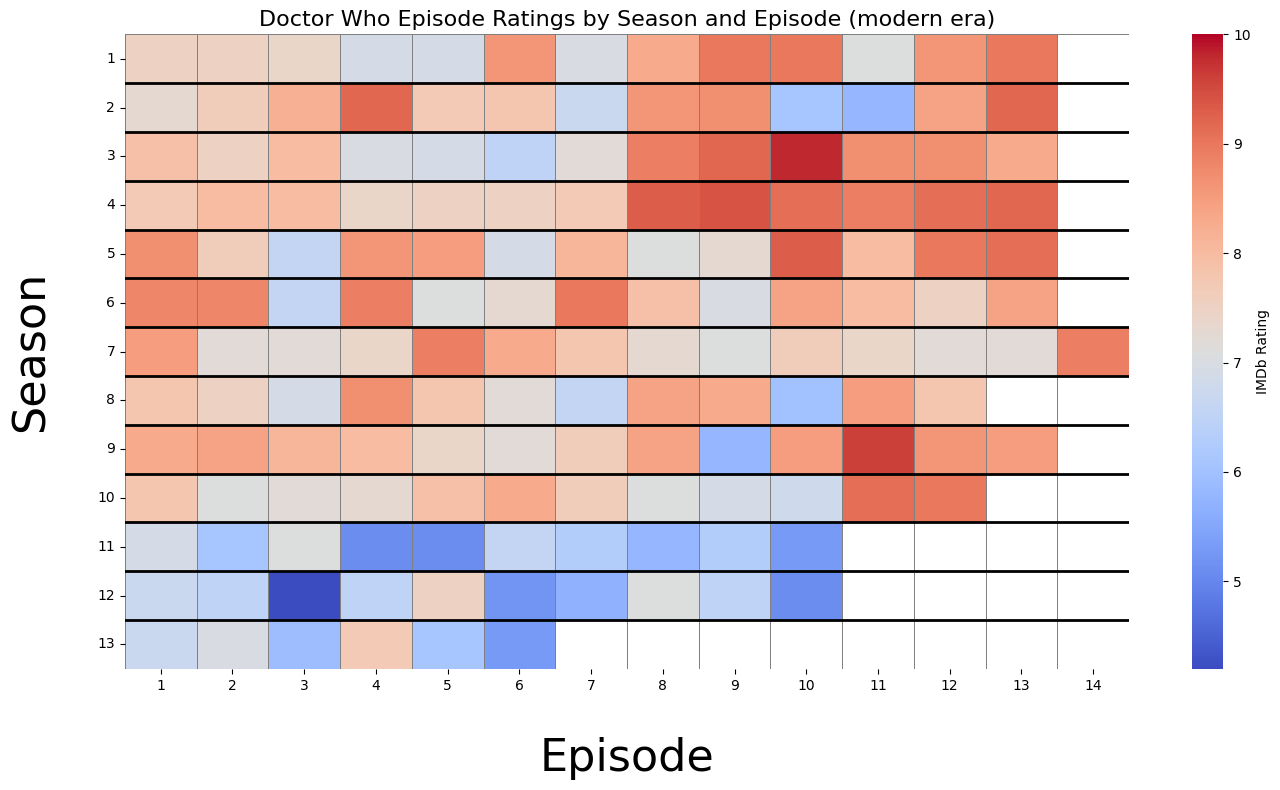

In [20]:
# Pivot the data so each row is a season and each column is an episode number
heatmap_data = episode_details[episode_details["era"] == "modern"].pivot_table(
    index="season",
    columns="episode",
    values="rating"
)

# Create the heatmap
plt.figure(figsize=(14, 8))
ax = sns.heatmap(
    heatmap_data,
    annot=False,
    fmt=".1f",
    cmap="coolwarm",
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "IMDb Rating"},
    vmin=heatmap_vmin,
    vmax=10.0,
)

for y in range(1, len(heatmap_data.index)):
    ax.axhline(y=y, color='black', linewidth=2)

plt.title("Doctor Who Episode Ratings by Season and Episode (modern era)", fontsize=16)
plt.xlabel("Episode", fontsize=32, labelpad=32)
plt.ylabel("Season", rotation=90, labelpad=32, fontsize=32)

plt.xticks(ticks=np.arange(len(heatmap_data.columns))+0.5, labels=heatmap_data.columns.astype(int), fontsize=10)
plt.yticks(ticks=np.arange(len(heatmap_data.index))+0.5, labels=heatmap_data.index.astype(int), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

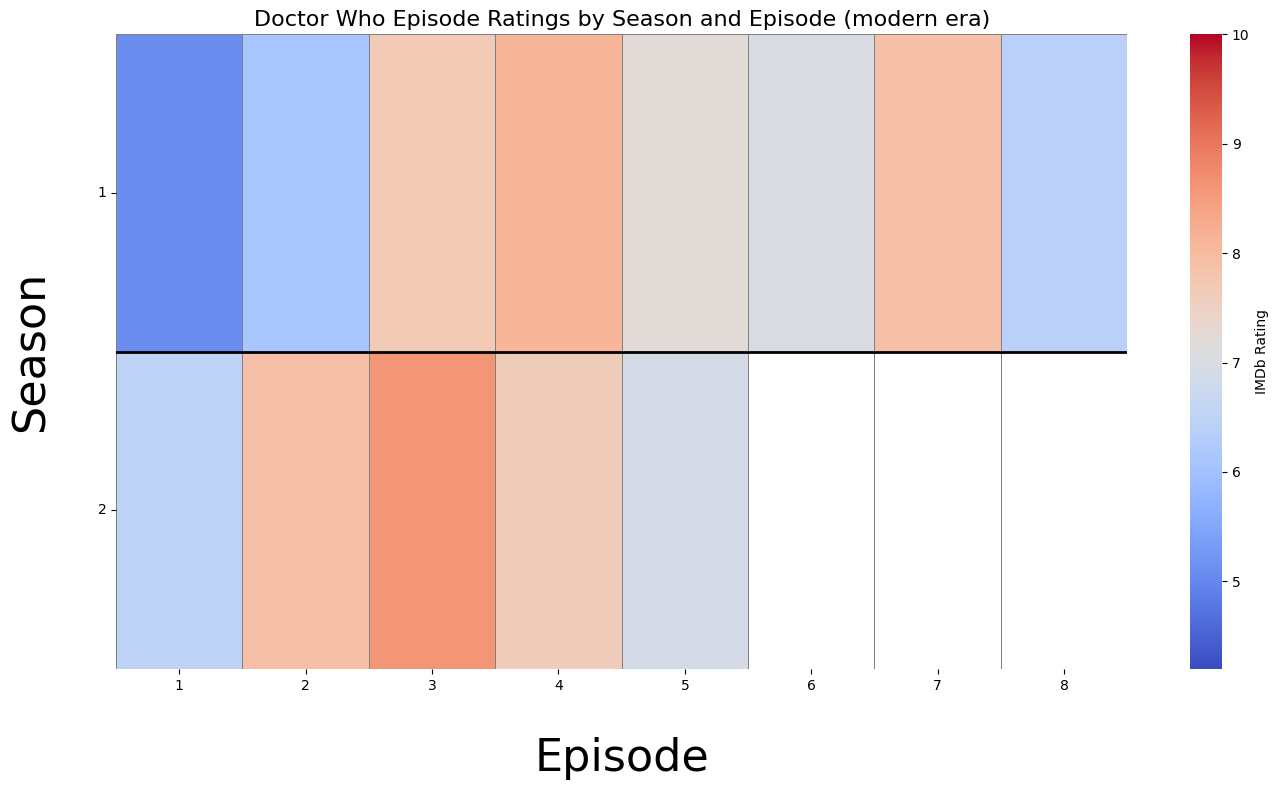

In [21]:
# Pivot the data so each row is a season and each column is an episode number
heatmap_data = episode_details[episode_details["era"] == "gatwa"].pivot_table(
    index="season",
    columns="episode",
    values="rating"
)

# Create the heatmap
plt.figure(figsize=(14, 8))
ax = sns.heatmap(
    heatmap_data,
    annot=False,
    fmt=".1f",
    cmap="coolwarm",
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "IMDb Rating"},
    vmin=heatmap_vmin,
    vmax=10.0,
)

for y in range(1, len(heatmap_data.index)):
    ax.axhline(y=y, color='black', linewidth=2)

plt.title("Doctor Who Episode Ratings by Season and Episode (modern era)", fontsize=16)
plt.xlabel("Episode", fontsize=32, labelpad=32)
plt.ylabel("Season", rotation=90, labelpad=32, fontsize=32)

plt.xticks(ticks=np.arange(len(heatmap_data.columns))+0.5, labels=heatmap_data.columns.astype(int), fontsize=10)
plt.yticks(ticks=np.arange(len(heatmap_data.index))+0.5, labels=heatmap_data.index.astype(int), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

## Timeline of Episode Ratings

To see how audience reception has evolved over time, let's plot each episode’s IMDb rating against its release year. Each point represents a single episode, with color indicating the Doctor and point size loosely reflecting the number of user votes.

This lets us:
- Observe shifts in episode quality over the decades
- Compare the consistency and reception of different Doctors
- Identify standout highs and lows across the series

Note: Although we approximate episode air dates using the release year, the timeline still gives a clear picture of long-term trends across the classic, modern, and gatwa eras.

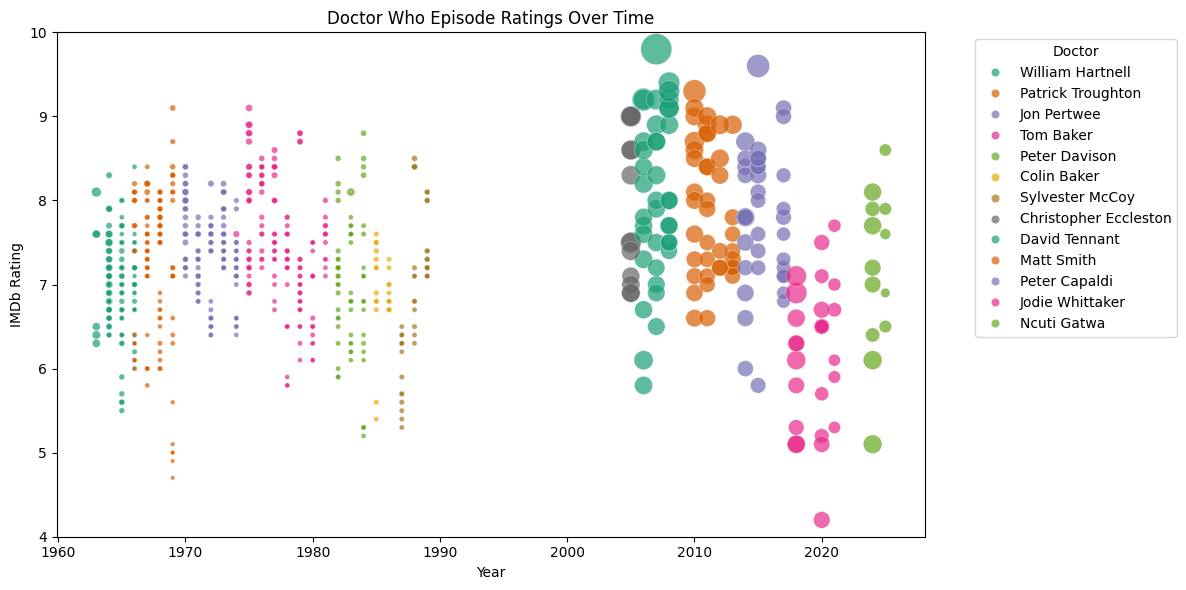

In [22]:
episode_plot = episode_details.copy()
episode_plot['votes'] = episode_plot['votes'].astype(int)

palette = sns.color_palette("Dark2", episode_details["doctor"].nunique())



plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(
    data=episode_plot,
    x='year',
    y='rating',
    hue='doctor',
    size='votes',
    alpha=0.7,
    palette=palette,  
    sizes=(10, 500),  # Adjust min/max point size
    legend='brief',
)

# Get current legend handles and labels
handles, labels = scatter.get_legend_handles_labels()

# Filter out size-related legend entries (those that aren't doctors)
# You can do this more dynamically, but if "doctor" is categorical, this works well:
doctor_labels = episode_plot['doctor'].unique().tolist()
filtered = [(h, l) for h, l in zip(handles, labels) if l in doctor_labels]

# Unpack and apply
new_handles, new_labels = zip(*filtered)
plt.legend(new_handles, new_labels, title='Doctor', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Doctor Who Episode Ratings Over Time')
plt.xlabel('Year')
plt.ylabel('IMDb Rating')
plt.ylim(4, 10)
plt.tight_layout()
plt.show()


# Relationships between numeric features of the dataset
It makes sense to explore relationships between quantitative variables in your dataset. For example, are longer episodes more likely to have higher ratings. A quick look at the plot below should be enough to convince you that this is not a strong relationship. 

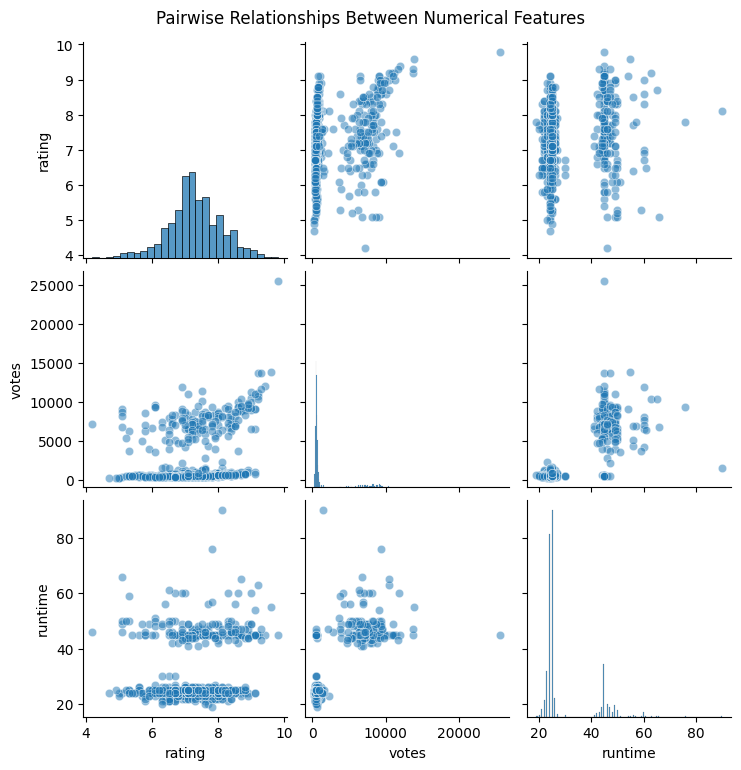

In [23]:
# Select only numeric columns
numeric_data = episode_details[["rating", "votes", "runtime"]]

sns.pairplot(numeric_data, plot_kws={"alpha": 0.5})
plt.suptitle("Pairwise Relationships Between Numerical Features", y=1.02)
plt.show()


## Comparing Doctors by Average Rating

Let’s compare how each Doctor fares based on their average episode rating. The **naive average** of the ratings score gives a rough idea of popularity, but doesn't account for vote volume or episode count. The **vote-weighted rating** improves on this by giving more influence to episodes with more IMDb votes. Instead of treating each episode equally, it reflects how viewers collectively rated a Doctor’s run — factoring in which episodes had the most engagement.

Finally, we compute a **shrinkage-adjusted rating**, which regularizes the vote-weighted average based on how many episodes each Doctor appeared in. This helps reduce the influence of small sample sizes — for instance, a Doctor with only a handful of highly-rated episodes won't automatically top the list unless there's enough evidence to support it.

Together, these three metrics provide a fairer and more robust way to compare how each Doctor’s era was received. That said, as we’ll see, the differences between them are relatively small — suggesting a reassuring consistency across the various approaches.


In [24]:
# Compute global average for shrinkage adjustment
global_avg = (episode_details['rating'] * episode_details['votes']).sum() / episode_details['votes'].sum()
shrinkage_C = 5  # shrinkage strength

# Group by doctor and compute all three metrics
doctor_stats = episode_details.groupby('doctor', as_index=False, observed=True).agg(
    average_rating=('rating', 'mean'),
    vote_weighted_numerator=('rating', lambda x: (x * episode_details.loc[x.index, 'votes']).sum()),
    total_votes=('votes', 'sum'),
    num_episodes=('rating', 'count')
)

doctor_stats['vote_weighted_rating'] = doctor_stats['vote_weighted_numerator'] / doctor_stats['total_votes']
doctor_stats['shrinkage_rating'] = (
    (shrinkage_C * global_avg + doctor_stats['vote_weighted_rating'] * doctor_stats['num_episodes']) /
    (shrinkage_C + doctor_stats['num_episodes'])
)

# Keep only relevant columns
doctor_scores = doctor_stats[['doctor', 'average_rating', 'vote_weighted_rating', 'shrinkage_rating']].copy()

# Ensure 'doctor' is a categorical column with the desired order
doctor_scores['doctor'] = pd.Categorical(doctor_scores['doctor'], categories=doctor_order, ordered=True)
doctor_scores = doctor_scores.sort_values('doctor')

# Drop any unused categories (in case we don't have data for Ncuti Gatwa)
doctor_scores['doctor'] = doctor_scores['doctor'].cat.remove_unused_categories()

doctor_scores.style.set_properties(**{'text-align': 'left'}).hide(axis='index')

doctor,average_rating,vote_weighted_rating,shrinkage_rating
William Hartnell,6.998413,7.040943,7.063955
Patrick Troughton,7.278740,7.407231,7.416194
Jon Pertwee,7.405469,7.469068,7.475639
Tom Baker,7.490698,7.615295,7.616102
Peter Davison,6.976712,7.083963,7.119853
Colin Baker,6.888889,6.910383,7.024986
Sylvester McCoy,6.900000,6.982377,7.052747
Christopher Eccleston,7.907692,7.951372,7.865948
David Tennant,8.069231,8.233240,8.166263
Matt Smith,7.912500,8.016461,7.975060


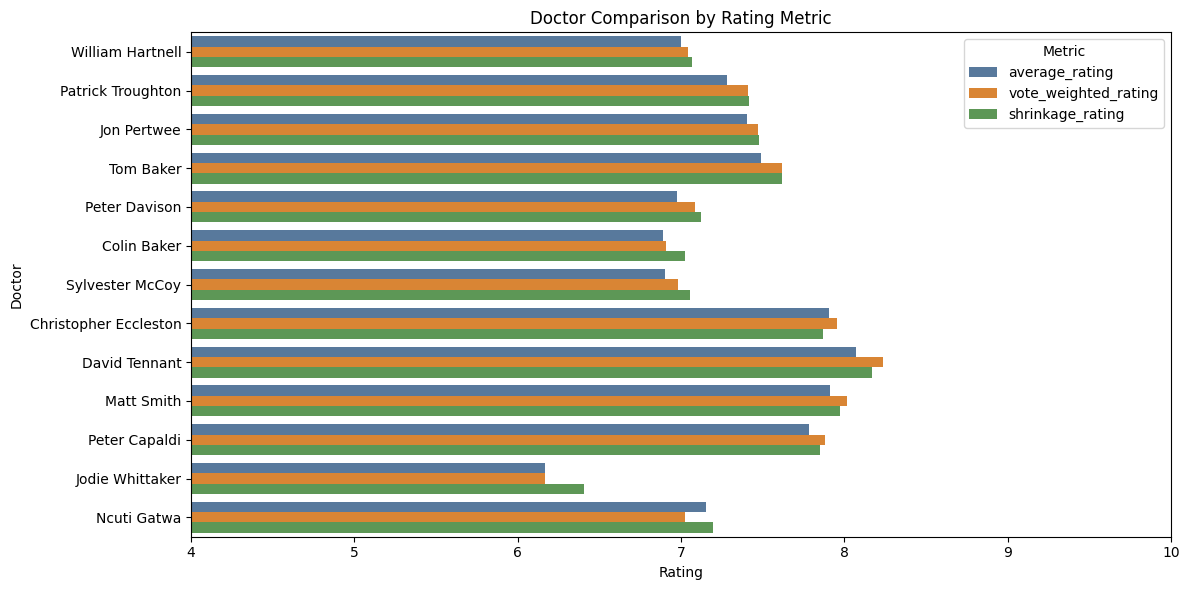

In [25]:
# Melt for plotting
melted = doctor_scores.melt(id_vars='doctor', var_name='metric', value_name='rating')

palette = {
    'average_rating': '#4C78A8',   # soft blue
    'vote_weighted_rating': '#F58518',  # soft orange
    'shrinkage_rating': '#54A24B'  # soft green
}

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=melted, x='rating', y='doctor', hue='metric', palette=palette)
plt.title('Doctor Comparison by Rating Metric')
plt.xlabel('Rating')
plt.ylabel('Doctor')
plt.legend(title='Metric')
plt.xlim(4, 10)



plt.tight_layout()
plt.show()


## Observations from the Doctor Rankings

From the chart above, it's clear that **David Tennant** stands out — he ranks highest across all three rating metrics. More broadly, we see a consistent trend: all of the modern-era Doctors (with the exception of Jodie Whittaker) are rated higher than their classic-era counterparts. While this doesn’t necessarily reflect differences in quality - factors like generational shifts, voting behavior, or nostalgia could also play a role - the pattern is notable. 

It's also worth noting that **Jodie Whittaker**, the first female Doctor, consistently ranks lower across all rating metrics. While this may reflect audience reception to the episodes during her tenure, it's difficult to disentangle whether the lower ratings are driven by the writing and direction of her era, broader shifts in the show's tone, or potential gender bias in how viewers respond to a female lead. 


## Who are the best writers?

Some writers have had a lasting impact on the tone and quality of Doctor Who. Since many episodes are co-written, we first split the data so that each writer is evaluated individually, regardless of their collaborators.

We then calculate the same three metrics used earlier for comparing Doctors: the **naive average**, the **vote-weighted average**, and the **shrinkage-adjusted average**. 

This helps highlight the most consistently well-rated writers over time, while avoiding over-emphasizing those with a small number of standout episodes.

In [26]:
# Explode writers (split multiple writers per episode)
writer_exploded = episode_details[['writers', 'rating', 'votes']].copy()
writer_exploded['writers'] = writer_exploded['writers'].str.split(',').apply(lambda x: [w.strip() for w in x])
writer_exploded = writer_exploded.explode('writers')

# Compute weighted rating column beforehand
writer_exploded['weighted_rating'] = writer_exploded['rating'] * writer_exploded['votes']

# Group cleanly
writer_stats = writer_exploded.groupby('writers', as_index=False).agg(
    average_rating=('rating', 'mean'),
    vote_weighted_rating=('weighted_rating', lambda x: x.sum()),
    total_votes=('votes', 'sum'),
    num_episodes=('rating', 'count')
)

# Final vote-weighted rating
writer_stats['vote_weighted_rating'] = writer_stats['vote_weighted_rating'] / writer_stats['total_votes']

# Shrinkage
writer_stats['shrinkage_rating'] = (
    (shrinkage_C * global_avg + writer_stats['vote_weighted_rating'] * writer_stats['num_episodes']) /
    (shrinkage_C + writer_stats['num_episodes'])
)

# Keep final scores
writer_scores = writer_stats[['writers', 'average_rating', 'vote_weighted_rating', 'shrinkage_rating', 'num_episodes']]



In [27]:
writer_scores.sort_values("shrinkage_rating", ascending=False).head(10).style.set_properties(**{'text-align': 'left'}).hide(axis='index')

writers,average_rating,vote_weighted_rating,shrinkage_rating,num_episodes
Paul Cornell,8.800000,8.818057,8.084175,3
Steven Moffat,7.889773,8.098238,8.073809,88
Terry Nation,7.650000,8.077709,8.054874,90
Malcolm Hulke,7.619298,8.086650,8.050940,57
Robert Banks Stewart,8.216667,8.099189,7.965265,12
Lewis Greifer,8.350000,8.352418,7.958767,4
Matt Jones,8.650000,8.650527,7.931470,2
Richard Curtis,9.300000,9.300000,7.919872,1
Douglas Adams,7.923077,8.023712,7.918193,13
Dave Martin,7.122222,7.932130,7.896973,36


## Who are the best directors?

Doctor Who has featured a wide range of directors over the years, each leaving their mark on the show's tone, pacing, and visual style. To evaluate their impact, we compute the same three metrics used for Doctors and writers. 

In [28]:
# Explode directors (split multiple directors per episode)
director_exploded = episode_details[['directors', 'rating', 'votes']].copy()
director_exploded['directors'] = director_exploded['directors'].str.split(',').apply(lambda x: [w.strip() for w in x])
director_exploded = director_exploded.explode('directors')

# Compute weighted rating column beforehand
director_exploded['weighted_rating'] = director_exploded['rating'] * director_exploded['votes']

# Group cleanly
director_stats = director_exploded.groupby('directors', as_index=False).agg(
    average_rating=('rating', 'mean'),
    vote_weighted_rating=('weighted_rating', lambda x: x.sum()),
    total_votes=('votes', 'sum'),
    num_episodes=('rating', 'count')
)

# Final vote-weighted rating
director_stats['vote_weighted_rating'] = director_stats['vote_weighted_rating'] / director_stats['total_votes']

# Shrinkage
director_stats['shrinkage_rating'] = (
    (shrinkage_C * global_avg + director_stats['vote_weighted_rating'] * director_stats['num_episodes']) /
    (shrinkage_C + director_stats['num_episodes'])
)

# Keep final scores
director_scores = director_stats[['directors', 'average_rating', 'vote_weighted_rating', 'shrinkage_rating', 'num_episodes']]


In [29]:
director_scores.sort_values("shrinkage_rating", ascending=False).head(10).style.set_properties(**{'text-align': 'left'}).hide(axis='index')

directors,average_rating,vote_weighted_rating,shrinkage_rating,num_episodes
Rachel Talalay,8.766667,8.877619,8.316813,6
Hettie Macdonald,8.833333,9.285968,8.259642,3
Graeme Harper,8.288889,8.403469,8.238333,18
Toby Haynes,8.925000,8.928069,8.214612,4
David Maloney,7.943478,8.073283,8.031181,46
Nick Hurran,8.450000,8.487363,8.018743,4
Adam Smith,8.600000,8.607968,8.005392,3
Joe Ahearne,8.320000,8.359224,8.001535,5
James Hawes,8.375000,8.440256,7.997806,4
Charlie Palmer,8.033333,8.221761,7.959073,6


## What Drives Episode Ratings? A Frequentist Analysis

So far, we’ve compared average ratings across different Doctors, writers, and directors. But how much does each of these roles actually *influence* how an episode is received?

To explore this, we use a frequentist linear regression model, treating the Doctor, writers, and directors as categorical variables. This lets us statistically estimate the contribution of each group to the variation in IMDb ratings.

In doing so, we move beyond surface-level averages and toward a deeper understanding of which creative forces matter most in shaping how audiences respond to Doctor Who episodes.


In [30]:
# Since writers or directors that only appear a few times could introduce noise, we will limit to frequent contributors.
# We will therefore filter out directors and writers appearing in fewer than 3 episodes
model_df = episode_details.copy()

# Step 1: Split writers and directors into lists
model_df['writers_list'] = model_df['writers'].str.split(',').apply(lambda x: [w.strip() for w in x])
model_df['directors_list'] = model_df['directors'].str.split(',').apply(lambda x: [d.strip() for d in x])


# Step 2: Explode writers and directors to count individual appearances
all_writers = model_df.explode('writers_list')
all_directors = model_df.explode('directors_list')


# Step 3: Count appearances
writer_counts = all_writers['writers_list'].value_counts()
director_counts = all_directors['directors_list'].value_counts()


# Step 4: Keep only writers/directors with ≥ 3 appearances
valid_writers = writer_counts[writer_counts >= 3].index
valid_directors = director_counts[director_counts >= 3].index


# Step 5: Filter episode-level data to only include valid contributors
def filter_valid_contributors(contributors, valid_set):
    return [c for c in contributors if c in valid_set]

model_df['writers_list'] = model_df['writers_list'].apply(lambda x: filter_valid_contributors(x, valid_writers))
model_df['directors_list'] = model_df['directors_list'].apply(lambda x: filter_valid_contributors(x, valid_directors))


# Step 6: Drop episodes where either list is now empty
model_df_filtered = model_df[
    (model_df['writers_list'].str.len() > 0) &
    (model_df['directors_list'].str.len() > 0)
].copy()

model_df_filtered.drop(columns=['writers', 'directors'], inplace=True)


In [31]:
# Explode the dataset as previously described
model_df['writers_list'] = model_df['writers'].str.split(',').apply(lambda x: [w.strip() for w in x])
model_df['directors_list'] = model_df['directors'].str.split(',').apply(lambda x: [d.strip() for d in x])

expanded_rows = []
for idx, row in model_df.iterrows():
    writers = row['writers_list']
    directors = row['directors_list']
    weight = 1 / (len(writers) * len(directors))
    for writer in writers:
        for director in directors:
            expanded_rows.append({
                'rating': row['rating'],
                'doctor': row['doctor'],
                'writer': writer,
                'director': director,
                'weight': weight
            })

# Final expanded dataset
model_df_expanded = pd.DataFrame(expanded_rows)


In [32]:
# Define and fit the model using the formula API (this retains design info)
wls_model = smf.wls(
    formula="rating ~ C(doctor) + C(writer) + C(director)",
    data=model_df_expanded,
    weights=model_df_expanded["weight"]
).fit()

# Run ANOVA
anova_results = anova_lm(wls_model)

# Add percentage of explained variance
anova_results["percent_variance"] = 100 * anova_results["sum_sq"] / anova_results["sum_sq"].sum()

anova_results


,df,sum_sq,mean_sq,F,PR(>F),percent_variance
C(doctor),12.0,340.753552,28.396129,325.870020,0.000000e+00,27.111984
C(writer),114.0,200.612974,1.759763,20.194794,5.920627e-271,15.961729
C(director),118.0,505.029125,4.279908,49.115626,0.000000e+00,40.182535
Residual,2415.0,210.441735,0.087139,NaN,NaN,16.743752


## Observations from Frequentist Analysis of Rating Variation

To understand the relative influence of the Doctor, writers, and directors on episode ratings, we fit a weighted linear model and used ANOVA to decompose the total variation in ratings.

The results were surprising: directors accounted for the **largest share of the explained variance**, followed by the Doctor and then the writers:

- **Directors:** ~40% of the variance
- **Doctors:** ~27%
- **Writers:** ~16%
- **Residual (unexplained):** ~17%

This suggests that while the Doctor is central to the show’s identity, it’s the creative vision of directors that has the strongest impact on how episodes are rated. The wide range of directorial styles, along with a larger and more diverse pool of directors, may contribute to this variability. The Doctor, though iconic, tends to bring more consistency than fluctuation across episodes.


## Conclusion

In this notebook, we explored the IMDb ratings of Doctor Who episodes to answer the age-old fan debate: *who is the best Doctor?*

Along the way, we:
- Collected and merged IMDb data,
- Cleaned and enriched it with metadata on Doctors, writers, and directors,
- Highlighted the highest- and lowest-rated episodes, and visualized trends across seasons and time,
- Explored correlations between features,
- Compared different rating metrics (naive, vote-weighted, and shrinkage-adjusted),
- Assessed the contributions of Doctors, writers and directors,
- And finally, used a frequentist linear model to understand how much each creative role contributes to rating variability.

While fan opinions will always vary, our data-driven analysis showed that **directors have the greatest influence** on episode ratings—more than the Doctor or the writers. The Doctor still matters, of course—but in the grand machinery of the show, it’s the behind-the-scenes storytelling and direction that most strongly shape how episodes are received.


## What We Learned & What's Next
This analysis revealed that directors appear to have the strongest influence on IMDb episode ratings, followed by the Doctor and then the writers. While this doesn't capture every nuance—like story arcs, companions, or visual effects—it gives a structured view of creative impact across the show’s long history.

There are plenty of directions this analysis could be taken further. For example, one could:

- Compare **genre** or **theme** (e.g., historical vs. sci-fi-heavy episodes),

- Explore the influence of **companions** or recurring villains,

- Apply similar methods to other long-running shows like *Game of Thrones* or *The Simpsons*,

- Use sentiment analysis from written reviews to investigate more subtle questions - such as the role of gender/race bias, shifts in audience expectations over time, divergence between fan and casual viewer perspectives, or how different creative choices (like tone, pacing, or visual effects) influence reception beyond the numeric score

There’s still a lot left to explore. This analysis scratched the surface, but deeper questions about storytelling, audience response, and creative choices remain open - and worth digging into.